In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

### Reading + Cleaning the Data

In [2]:
fname = "SPX_database_2010.xlsx"
df_SPX = pd.read_excel(fname, sheet_name="SPX_memb")[["Ticker", "Name"]]
df_mktcap_inicial = pd.read_excel(fname, sheet_name="mkt_cap")
df_price_inicial  = pd.read_excel(fname, sheet_name="prices")
df_total_ret_inicial = pd.read_excel(fname, sheet_name="total_ret")

In [3]:
for df in (df_price_inicial, df_mktcap_inicial, df_total_ret_inicial):
    df["Dates"] = pd.to_datetime(df["Dates"], errors="coerce")
    df.sort_values("Dates", inplace=True)
    df.reset_index(drop=True, inplace=True)

df_price = df_price_inicial[df_price_inicial["Dates"].dt.year >= 2014].reset_index(drop=True)
df_mktcap = df_mktcap_inicial[df_mktcap_inicial["Dates"].dt.year >= 2014].reset_index(drop=True)
df_total_ret = df_total_ret_inicial[df_total_ret_inicial["Dates"].dt.year >= 2014].reset_index(drop=True)

In [4]:
def _complete_cols(df):
    cols = [c for c in df.columns if c != "Dates"]
    complete = [c for c in cols if not df[c].isna().any()]
    return df[["Dates"] + complete].copy()

df_price_v1 = _complete_cols(df_price)
df_mktcap_v1 = _complete_cols(df_mktcap)
df_total_ret_v1 = _complete_cols(df_total_ret)

### Choosing 30 stocks and aligning data

In [5]:
def _choose_30(spx_df, px_df, tri_df, mkt_df, random_state=42):
    spx = set(spx_df["Ticker"].astype(str).str.strip())
    tick_px = [c for c in px_df.columns  if c != "Dates" and c in spx]
    tick_tri = [c for c in tri_df.columns if c != "Dates"]
    tick_mkt = [c for c in mkt_df.columns if c != "Dates"]
    
    eligible = sorted(set(tick_px) & set(tick_tri) & set(tick_mkt))
    rng = np.random.default_rng(random_state)
    
    return sorted(rng.choice(eligible, size=30, replace=False))


def _align_on_dates(px, tri, mkt, tickers):
    p = px[["Dates"] + tickers].copy()
    t = tri[["Dates"] + tickers].copy()
    m = mkt[["Dates"] + tickers].copy()

    pt = p.merge(t, on="Dates", suffixes=("_px", "_tri"))
    ptm = pt.merge(m, on="Dates")
    prices = pd.concat([ptm[["Dates"]], ptm[[f"{x}_px"  for x in tickers]].set_axis(tickers, axis=1)], axis=1)
    tris = pd.concat([ptm[["Dates"]], ptm[[f"{x}_tri" for x in tickers]].set_axis(tickers, axis=1)], axis=1)
    mktcap = pd.concat([ptm[["Dates"]], ptm[[x for x in tickers]]], axis=1)
    
    return prices, tris, mktcap


tickers30 = _choose_30(df_SPX, df_price_v1, df_total_ret_v1, df_mktcap_v1, random_state=42)
prices_30, tri_30, mktcap_30 = _align_on_dates(df_price_v1, df_total_ret_v1, df_mktcap_v1, tickers30)

### Separating month windows

In [6]:
dates_series = pd.Series(prices_30["Dates"]).reset_index(drop=True)
groups = dates_series.groupby([dates_series.dt.year, dates_series.dt.month], sort=True).groups

month_windows = []
for _, locs in groups.items():
    locs = sorted(locs)
    month_windows.append((locs[0], locs[-1]))

In [7]:
mktcap_30


,Dates,ARE UN Equity,ATO UN Equity,AVY UN Equity,BK UN Equity,CHRW UW Equity,CLX UN Equity,FCX UN Equity,GIS UN Equity,GM UN Equity,...,ON UW Equity,PFE UN Equity,PHM UN Equity,PRU UN Equity,RCL UN Equity,SJM UN Equity,SNA UN Equity,UDR UN Equity,VLO UN Equity,ZBH UN Equity
0,2014-01-01,4544.2116,4131.2625,4849.1489,40129.3449,8846.3891,11970.1786,39179.9754,31170.6075,56767.3574,...,3662.0843,198515.1986,7802.8793,42697.86,10429.4840,10894.4273,6368.5593,5854.7595,27193.9377,15933.7069
1,2014-01-02,4552.0686,4063.0448,4793.1117,39692.9067,8767.5389,11763.7073,39065.7783,30852.0940,56878.4753,...,3559.8659,197413.4166,7691.7927,42021.88,10374.4994,10727.2574,6312.1541,5834.7004,26907.9697,15771.2750
2,2014-01-03,4599.9250,4069.4118,4787.3147,40152.3154,8685.6560,11806.2920,38743.9502,30764.6589,54961.6915,...,3577.6430,197802.2808,7676.4704,41767.23,10374.4994,10672.5855,6324.3655,5937.5035,26627.3973,15839.6674
3,2014-01-06,4582.7824,4019.3855,4775.7208,40140.8301,8584.0605,11757.2550,38432.5037,30814.6218,56114.5397,...,3568.7545,197996.7130,7599.8589,41901.50,10152.3615,10608.4512,6258.6563,5980.1291,26886.3872,15942.2559
4,2014-01-07,4595.6393,4109.4328,4794.0778,39669.9363,8594.6749,11677.2474,38058.7678,31133.1353,55836.7449,...,3599.8644,199228.1164,7484.9417,42058.92,10130.3676,10673.6369,6273.1938,5950.0404,27744.2912,16260.2803
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3018,2025-07-28,13684.5120,24568.8861,13630.6912,71994.1521,12049.9708,15682.6872,62891.2091,27040.0104,50888.5585,...,24513.1544,138211.2374,23048.3026,36727.50,95589.2509,11596.5156,17032.9055,13218.7039,44966.8399,18989.4409
3019,2025-07-29,13746.7772,24796.0228,13467.3042,72881.2906,11848.1288,15658.0366,62086.9369,27132.2230,49612.7742,...,24396.1465,138154.3838,23095.6540,36617.76,90801.6416,11926.1681,16971.8744,13450.6110,44960.6269,18785.6575
3020,2025-07-30,13495.9867,24810.3182,13133.6601,73188.9274,11594.0452,15552.0392,56212.8779,26692.8568,49612.7742,...,24258.2443,135368.5546,22365.6530,36030.12,89949.4996,11639.1891,16810.6896,13182.2614,43295.5336,18463.1655
3021,2025-07-31,13219.2524,24765.8438,13082.9720,72580.8082,13692.0153,15475.6224,57792.6982,26568.0985,50783.8299,...,23552.0181,132412.1645,22278.8421,36667.32,86342.2843,11451.4258,16754.3531,13016.6135,42655.5910,18132.7595


# Calculate daily returns and values

In [8]:
tickers = tickers30
n = len(tickers)

capital_ew = 100_000_000.0
capital_vw = 100_000_000.0

ew_vals_parts = []
vw_vals_parts = []
w_ew_rows, w_vw_rows = [], []
s_ew_rows, s_vw_rows = [], []


for start_idx, end_idx in month_windows:
    prev_idx = start_idx - 1

    w_ew = pd.Series(1.0 / n, index=tickers)

    prev_mktcap = (
        mktcap_30.iloc[prev_idx][tickers]      # positional previous row
        .astype(float)
        .replace([np.inf, -np.inf], np.nan)
        .fillna(0.0)
    )
    total_prev = float(prev_mktcap.sum())
    w_vw = (prev_mktcap / total_prev) if total_prev > 0 else pd.Series(1.0 / n, index=tickers)

    prices_0 = (prices_30.loc[start_idx, tickers])
    px_safe = prices_0.replace(0.0, np.nan)

    shares_ew = (w_ew * capital_ew) / px_safe
    shares_vw = (w_vw * capital_vw) / px_safe
    shares_ew = shares_ew
    shares_vw = shares_vw

    tri_win = tri_30.loc[start_idx:end_idx, tickers]
    tri_base = tri_win.iloc[0].replace(0.0, np.nan)
    growth = tri_win.divide(tri_base, axis=1).fillna(1.0)

    start_pos_val_ew = shares_ew * prices_0
    start_pos_val_vw = shares_vw * prices_0

    vals_ew = growth.mul(start_pos_val_ew, axis=1).sum(axis=1)
    vals_vw = growth.mul(start_pos_val_vw, axis=1).sum(axis=1)

    ew_vals_parts.append(vals_ew)
    vw_vals_parts.append(vals_vw)

    rebalance_date = prices_30.loc[start_idx, "Dates"]
    w_ew_rows.append({"rebalance_date": rebalance_date, **{f"w_{t}": w_ew[t] for t in tickers}})
    w_vw_rows.append({"rebalance_date": rebalance_date, **{f"w_{t}": w_vw[t] for t in tickers}})
    s_ew_rows.append({"rebalance_date": rebalance_date, **{f"s_{t}": shares_ew[t] for t in tickers}})
    s_vw_rows.append({"rebalance_date": rebalance_date, **{f"s_{t}": shares_vw[t] for t in tickers}})

    capital_ew = float(vals_ew.iloc[-1])
    capital_vw = float(vals_vw.iloc[-1])



EW_Value = pd.concat(ew_vals_parts)
VW_Value = pd.concat(vw_vals_parts)
EW_Value.index = prices_30.loc[EW_Value.index, "Dates"].values
VW_Value.index = prices_30.loc[VW_Value.index, "Dates"].values

EW_Return = EW_Value.pct_change().rename("EW_Return")
VW_Return = VW_Value.pct_change().rename("VW_Return")

daily_returns = pd.concat([EW_Return, VW_Return], axis=1)
daily_values = pd.concat([EW_Value.rename("EW_Value"), VW_Value.rename("VW_Value")], axis=1)

weights_ew = pd.DataFrame(w_ew_rows)
weights_vw = pd.DataFrame(w_vw_rows)
shares_ew = pd.DataFrame(s_ew_rows)
shares_vw = pd.DataFrame(s_vw_rows)

display(daily_returns, daily_values, weights_ew, weights_vw, shares_ew, shares_vw)

/var/folders/pm/ps47mfm943x_nqjshcjsk5ch0000gn/T/ipykernel_63056/1279008340.py:64: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  EW_Return = EW_Value.pct_change().rename("EW_Return")
/var/folders/pm/ps47mfm943x_nqjshcjsk5ch0000gn/T/ipykernel_63056/1279008340.py:65: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  VW_Return = VW_Value.pct_change().rename("VW_Return")


,EW_Return,VW_Return
2014-01-01,NaN,NaN
2014-01-02,-1.154481e-02,-8.774450e-03
2014-01-03,-4.353954e-04,-5.020505e-03
2014-01-06,-2.083520e-03,4.366228e-03
2014-01-07,2.189098e-03,5.288264e-03
...,...,...
2025-07-28,-7.855133e-03,-4.785613e-03
2025-07-29,-1.013293e-03,7.769358e-03
2025-07-30,-1.251760e-02,4.827664e-04
2025-07-31,-1.175627e-03,-1.975873e-02


,EW_Value,VW_Value
2014-01-01,100000000.0,100000000.0
2014-01-02,98845519.15653,99122555.033153
2014-01-03,98802482.276353,98624909.739255
2014-01-06,98596625.283076,99055528.552033
2014-01-07,98812462.97933,99579360.302917
...,...,...
2025-07-28,435519432.421537,394730692.306235
2025-07-29,435078123.497661,397797496.371391
2025-07-30,429631989.146045,397989539.621395
2025-07-31,429126902.068333,390125772.20128


,rebalance_date,w_ARE UN Equity,w_ATO UN Equity,w_AVY UN Equity,w_BK UN Equity,w_CHRW UW Equity,w_CLX UN Equity,w_FCX UN Equity,w_GIS UN Equity,w_GM UN Equity,...,w_ON UW Equity,w_PFE UN Equity,w_PHM UN Equity,w_PRU UN Equity,w_RCL UN Equity,w_SJM UN Equity,w_SNA UN Equity,w_UDR UN Equity,w_VLO UN Equity,w_ZBH UN Equity
0,2014-01-01,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,...,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333
1,2014-02-03,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,...,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333
2,2014-03-03,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,...,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333
3,2014-04-01,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,...,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333
4,2014-05-01,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,...,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
135,2025-04-01,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,...,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333
136,2025-05-01,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,...,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333
137,2025-06-02,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,...,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333
138,2025-07-01,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,...,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333


,rebalance_date,w_ARE UN Equity,w_ATO UN Equity,w_AVY UN Equity,w_BK UN Equity,w_CHRW UW Equity,w_CLX UN Equity,w_FCX UN Equity,w_GIS UN Equity,w_GM UN Equity,...,w_ON UW Equity,w_PFE UN Equity,w_PHM UN Equity,w_PRU UN Equity,w_RCL UN Equity,w_SJM UN Equity,w_SNA UN Equity,w_UDR UN Equity,w_VLO UN Equity,w_ZBH UN Equity
0,2014-01-01,0.003356,0.006318,0.003301,0.018230,0.003451,0.003874,0.014677,0.006777,0.012768,...,0.006062,0.034095,0.005881,0.009102,0.021792,0.002948,0.004232,0.003271,0.010562,0.004577
1,2014-02-03,0.004852,0.004230,0.004611,0.035361,0.008598,0.011033,0.032591,0.029050,0.048542,...,0.003599,0.190845,0.007540,0.037847,0.010592,0.009816,0.005641,0.005912,0.026707,0.015563
2,2014-03-03,0.004838,0.004317,0.004472,0.033960,0.007352,0.010602,0.031671,0.029214,0.053808,...,0.003846,0.191630,0.007483,0.036614,0.010948,0.009696,0.006096,0.006068,0.023889,0.014856
3,2014-04-01,0.005014,0.004554,0.004691,0.038639,0.007446,0.011029,0.033126,0.030717,0.052785,...,0.003994,0.198096,0.007056,0.037805,0.011643,0.009726,0.006382,0.006265,0.027286,0.015378
4,2014-05-01,0.005237,0.005061,0.004624,0.038062,0.008592,0.011666,0.035336,0.032257,0.054747,...,0.004105,0.198004,0.006894,0.036982,0.011684,0.009925,0.006689,0.006437,0.030152,0.016154
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
135,2025-04-01,0.004732,0.007250,0.004153,0.017793,0.003578,0.005360,0.016077,0.009675,0.013827,...,0.005067,0.042466,0.006123,0.011696,0.016337,0.003723,0.005220,0.004420,0.012272,0.006657
136,2025-05-01,0.003604,0.007310,0.003835,0.016553,0.003024,0.005026,0.014836,0.008908,0.012534,...,0.004804,0.039693,0.005895,0.010437,0.016733,0.003548,0.004705,0.003976,0.010425,0.005845
137,2025-06-02,0.003263,0.006603,0.003734,0.017039,0.003063,0.004369,0.014854,0.007986,0.012820,...,0.004720,0.035895,0.005281,0.009885,0.018756,0.003221,0.004508,0.003689,0.010857,0.004901
138,2025-07-01,0.003243,0.006319,0.003541,0.016826,0.002941,0.003820,0.016071,0.007254,0.012213,...,0.005653,0.035574,0.005456,0.009818,0.021950,0.002704,0.004200,0.003492,0.010868,0.004658


,rebalance_date,s_ARE UN Equity,s_ATO UN Equity,s_AVY UN Equity,s_BK UN Equity,s_CHRW UW Equity,s_CLX UN Equity,s_FCX UN Equity,s_GIS UN Equity,s_GM UN Equity,...,s_ON UW Equity,s_PFE UN Equity,s_PHM UN Equity,s_PRU UN Equity,s_RCL UN Equity,s_SJM UN Equity,s_SNA UN Equity,s_UDR UN Equity,s_VLO UN Equity,s_ZBH UN Equity
0,2014-01-01,52394.425233,73389.109056,66414.292356,95401.640908,57136.327277,35935.029467,88323.617735,66786.883056,81559.416035,...,404530.744337,114801.204494,163639.338897,36145.449288,70293.828202,32168.821978,30435.841247,142755.174875,66137.566138,36870.790738
1,2014-02-03,47358.401106,70464.758657,68843.523883,106483.625910,57013.838158,38112.654897,105901.186514,70239.199250,93373.301471,...,407857.357729,113468.686287,167161.446260,40912.478271,68571.018268,35041.082475,33851.783162,136856.917957,67377.868513,37336.567900
2,2014-03-03,48133.844694,76368.312950,70973.061691,110011.586054,67750.130387,40457.757299,106794.677050,70318.276124,96825.994132,...,374980.668186,115653.075583,168480.021506,42246.888150,68451.176250,35396.963630,31430.472860,134075.305833,72514.358791,38284.391366
3,2014-04-01,48906.063753,74911.503703,68799.569240,99303.755545,67414.608586,39999.385551,106814.884078,67909.346926,102397.961090,...,372100.104109,116100.834808,179131.226889,40973.502492,62657.626227,36198.743914,30858.674716,135976.256142,63346.171570,38030.009862
4,2014-05-01,46899.556466,67285.498619,71171.624777,101631.822362,58800.278957,38595.082429,100977.476417,65497.349453,98865.340091,...,367846.521235,116849.439837,186206.172109,42508.320428,65596.965194,35508.905724,29742.266780,132963.405363,59788.604560,36478.589755
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
135,2025-04-01,146763.545637,86339.855330,74501.543689,159693.173986,130181.950027,90443.493914,350839.160367,224003.636718,283061.726297,...,332773.561810,545130.284628,129828.194728,119773.454963,64277.806961,112871.221606,39394.243432,296158.892734,100026.149131,119048.653420
136,2025-05-01,178171.071657,81666.375834,77216.929822,161677.420357,144897.209582,94422.694392,359278.222496,235360.202970,290373.364730,...,330336.365684,546649.397455,128386.692326,128588.617724,59253.159764,114980.399763,41966.315104,307073.241340,113869.429675,128474.956601
137,2025-06-02,194737.637997,87647.048659,76931.204476,152323.439027,141008.526889,104027.474132,337577.574212,250392.381389,284205.066148,...,318611.650320,577738.261066,138941.461862,130827.602361,51745.655727,121015.532184,42825.174902,327305.955195,105640.994580,148762.370811
138,2025-07-01,189885.708154,92057.184513,78112.361390,156035.150584,143877.391928,114493.980900,321102.982983,265925.670247,271854.437832,...,263891.537321,564879.648579,128657.325818,129766.847710,44889.198351,137392.777080,44499.422389,346171.962810,102489.576121,150378.337236


,rebalance_date,s_ARE UN Equity,s_ATO UN Equity,s_AVY UN Equity,s_BK UN Equity,s_CHRW UW Equity,s_CLX UN Equity,s_FCX UN Equity,s_GIS UN Equity,s_GM UN Equity,...,s_ON UW Equity,s_PFE UN Equity,s_PHM UN Equity,s_PRU UN Equity,s_RCL UN Equity,s_SJM UN Equity,s_SNA UN Equity,s_UDR UN Equity,s_VLO UN Equity,s_ZBH UN Equity
0,2014-01-01,5275.593473,13910.755670,6577.533118,52176.161324,5915.871305,4175.854435,38891.071944,13579.047508,31241.107625,...,73566.887329,117424.936281,28869.471048,9869.654748,45955.653891,2845.335671,3864.236183,14009.473216,20957.211255,5063.029033
1,2014-02-03,7268.952156,9428.560416,10041.533383,119112.359737,15507.388738,13302.347246,109181.279873,64545.425020,143380.253424,...,46432.467322,685018.714135,39868.485849,48981.696804,22976.180873,10881.189413,6040.686946,25592.668209,56922.739162,18381.340960
2,2014-03-03,7350.677622,10405.826551,10017.066792,117917.199406,15722.290500,13537.741163,106752.808728,64838.053491,164442.243187,...,45519.577206,699504.973176,39792.455509,48822.155501,23652.174640,10832.168320,6047.091842,25676.466985,54674.621196,17950.705398
3,2014-04-01,7527.335211,10470.148389,9906.294263,117774.293247,15406.833415,13541.271004,108606.580160,64026.727509,165904.992724,...,45611.518557,705942.748563,38795.194582,47545.527306,22391.386753,10806.594095,6045.245294,26147.512204,53054.246914,17951.219439
4,2014-05-01,7424.716807,10295.562903,9948.661839,116947.019934,15272.731895,13612.077853,107871.145577,63871.757435,163632.091296,...,45653.758410,699460.278948,38810.119334,47525.919317,23171.270518,10654.556926,6014.176088,25876.648444,54500.808523,17815.281165
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
135,2025-04-01,17322.278739,15614.944700,7717.451998,70879.951316,11619.872349,12092.869558,140698.430182,54059.152505,97634.157539,...,42060.512285,577461.641158,19830.924122,34944.967006,26195.573183,10483.415992,5129.509418,32651.230272,30620.043781,19770.007192
136,2025-05-01,16784.774412,15605.898444,7741.474541,69957.269691,11455.227782,12405.692918,139339.710836,54808.885991,95136.536165,...,41483.459323,567199.548659,19783.542794,35083.823038,25917.868621,10662.663444,5161.304862,31916.578797,31031.084100,19631.263307
137,2025-06-02,16986.734072,15469.965246,7678.932757,69372.252448,11542.773879,12147.597280,134026.360510,53447.985112,97383.959571,...,40192.166389,554292.646914,19611.646369,34565.509672,25941.153806,10418.234128,5160.116777,32273.896050,30656.177092,19488.601933
138,2025-07-01,16526.174106,15609.379605,7422.316840,70453.742772,11353.927308,11737.073227,138482.300944,51767.998788,89095.431159,...,40035.254632,539253.248531,18837.563485,34188.405508,26441.897768,9970.551752,5015.786306,32436.432415,29889.569434,18797.712175


In [9]:
daily_returns

,EW_Return,VW_Return
2014-01-01,NaN,NaN
2014-01-02,-1.154481e-02,-8.774450e-03
2014-01-03,-4.353954e-04,-5.020505e-03
2014-01-06,-2.083520e-03,4.366228e-03
2014-01-07,2.189098e-03,5.288264e-03
...,...,...
2025-07-28,-7.855133e-03,-4.785613e-03
2025-07-29,-1.013293e-03,7.769358e-03
2025-07-30,-1.251760e-02,4.827664e-04
2025-07-31,-1.175627e-03,-1.975873e-02


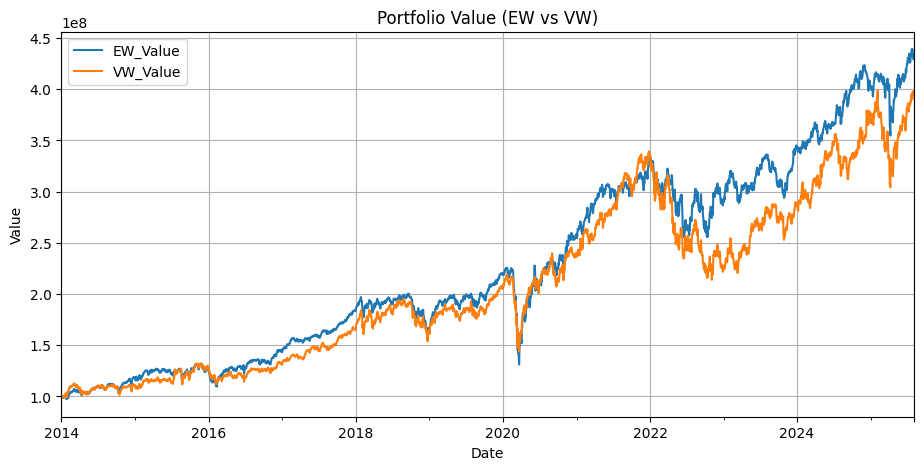

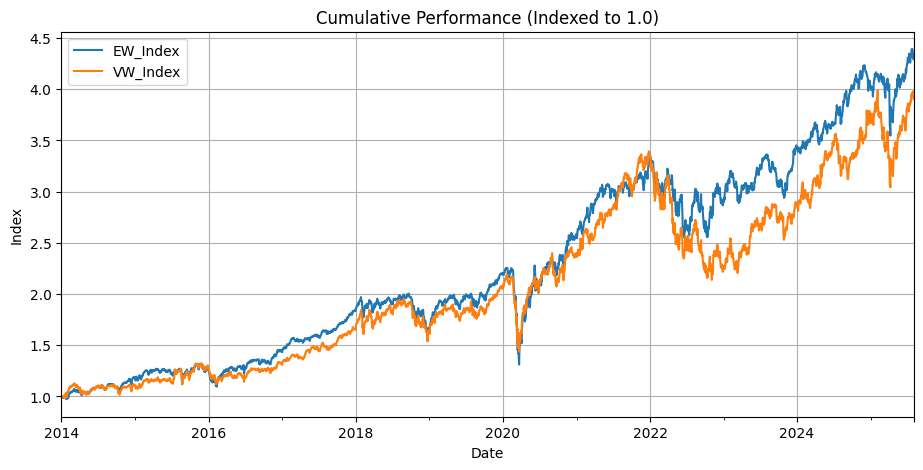

In [10]:
plt.figure(figsize=(11,5))
daily_values.plot(ax=plt.gca())
plt.title("Portfolio Value (EW vs VW)")
plt.xlabel("Date")
plt.ylabel("Value")
plt.legend()
plt.grid(True)

plt.figure(figsize=(11,5))
norm_vals = pd.DataFrame({
    "EW_Index": EW_Value / EW_Value.dropna().iloc[0],
    "VW_Index": VW_Value / VW_Value.dropna().iloc[0],
})
norm_vals.plot(ax=plt.gca())
plt.title("Cumulative Performance (Indexed to 1.0)")
plt.xlabel("Date")
plt.ylabel("Index")
plt.legend()
plt.grid(True)

# plt.figure(figsize=(11,5))
# rolling_vol = pd.DataFrame({
#     "EW_RollingVol_21d": daily_returns["EW_Return"].rolling(21).std() * np.sqrt(252),
#     "VW_RollingVol_21d": daily_returns["VW_Return"].rolling(21).std() * np.sqrt(252),
# })
# rolling_vol.plot(ax=plt.gca())
# plt.title("Rolling Volatility (21d, Annualized)")
# plt.xlabel("Date")
# plt.ylabel("Volatility")
# plt.legend()
# plt.grid(True)

plt.show()

# Calculating the yearly turnover

$$
\text{Turnover} = \frac{\min(\text{Total Buys}, \text{Total Sells})}{\text{Average Assets}}
$$

In [11]:
prices = prices_30[["Dates"] + tickers].copy()
prices["Dates"] = pd.to_datetime(prices["Dates"])
prices = prices.set_index("Dates")

def turnover(shares_df):
    rows = []
    for i in range(1, len(shares_df)):
        date_now = pd.to_datetime(shares_df.loc[i, "rebalance_date"])

        prev_shares = shares_df.loc[i-1, [f"s_{t}" for t in tickers]].to_numpy(float)
        curr_shares = shares_df.loc[i, [f"s_{t}" for t in tickers]].to_numpy(float)
        px = prices.loc[date_now, tickers].to_numpy(float)

        prev_val = prev_shares * px
        curr_val = curr_shares * px
        diff = curr_val - prev_val

        buys = diff[diff > 0].sum()
        sells = (-diff[diff < 0]).sum()
        assets = curr_val.sum()

        rows.append({
            "date": date_now, 
            "buys": buys, "sells": sells, 
            "assets": assets
        })

    trades = pd.DataFrame(rows)
    trades["year"] = trades["date"].dt.year
    
    out = (
        trades
        .groupby("year", as_index=False)
        .agg(total_buys=("buys", "sum"),
            total_sells=("sells", "sum"),
            avg_assets=("assets", "mean"))
    )
    out["turnover"] = out[["total_buys", "total_sells"]].min(axis=1) / out["avg_assets"]
    return out[["year", "turnover", "total_buys", "total_sells", "avg_assets"]]

turnover_ew = turnover(shares_ew)
turnover_vw = turnover(shares_vw)

display(turnover_ew, turnover_vw)

,year,turnover,total_buys,total_sells,avg_assets
0,2014,0.203432,2.593726e+07,2.188949e+07,1.076011e+08
1,2015,0.275770,3.413059e+07,3.543808e+07,1.237649e+08
2,2016,0.319488,4.183278e+07,4.134835e+07,1.294206e+08
3,2017,0.233013,3.739787e+07,4.003051e+07,1.604971e+08
4,2018,0.277943,5.802531e+07,5.277527e+07,1.898781e+08
5,2019,0.262233,5.488247e+07,5.082968e+07,1.938344e+08
6,2020,0.436488,9.293517e+07,9.276808e+07,2.125330e+08
7,2021,0.285116,8.350691e+07,1.007205e+08,2.928872e+08
8,2022,0.355393,1.043897e+08,1.051490e+08,2.937307e+08
9,2023,0.327275,1.020014e+08,1.067812e+08,3.116688e+08


,year,turnover,total_buys,total_sells,avg_assets
0,2014,0.393523,4.848864e+07,4.252915e+07,1.080729e+08
1,2015,0.086927,1.028788e+07,1.399252e+07,1.183504e+08
2,2016,0.077427,9.546836e+06,1.253124e+07,1.233006e+08
3,2017,0.068024,9.943024e+06,1.109216e+07,1.461688e+08
4,2018,0.087578,1.640497e+07,1.574924e+07,1.798304e+08
5,2019,0.097519,2.350846e+07,1.784711e+07,1.830113e+08
6,2020,0.115606,2.422415e+07,3.778843e+07,2.095403e+08
7,2021,0.084119,2.382016e+07,4.106928e+07,2.831716e+08
8,2022,0.105117,2.807167e+07,3.447599e+07,2.670504e+08
9,2023,0.066070,1.701132e+07,2.655603e+07,2.574733e+08


In [12]:
turnover_vw['turnover'].mean()

np.float64(0.10817534770815011)

In [13]:
turnover_ew['turnover'].mean()

np.float64(0.2874896328871151)

### Daily return per stock + Covariance matrix

In [14]:
stock_returns = prices.pct_change().dropna()
cov_matrix = stock_returns.cov()
corr_matrix = stock_returns.corr()

print("Stock Returns:\n", stock_returns.head())
print("Covariance Matrix:\n", cov_matrix)
print("Correlation Matrix:\n", corr_matrix)

Stock Returns:
             ARE UN Equity  ATO UN Equity  AVY UN Equity  BK UN Equity  \
Dates                                                                   
2014-01-02       0.001729      -0.016513      -0.011556     -0.010876   
2014-01-03       0.010513       0.001567      -0.001209      0.011574   
2014-01-06      -0.003727      -0.012293      -0.002422     -0.000286   
2014-01-07       0.002805       0.022403       0.003844     -0.011731   
2014-01-08      -0.002176       0.005312      -0.003225      0.003474   

            CHRW UW Equity  CLX UN Equity  FCX UN Equity  GIS UN Equity  \
Dates                                                                     
2014-01-02       -0.008913      -0.017249      -0.002915      -0.010218   
2014-01-03       -0.009339       0.003620      -0.008238      -0.002834   
2014-01-06       -0.011697      -0.004153      -0.008039       0.001624   
2014-01-07        0.001237      -0.006805      -0.009724       0.010336   
2014-01-08       -0.00

# Statistics
### Sharpe, GeometricAvg_Annual, Std_Annual and IR_BenchMark

In [15]:
#Normality and Risk Measures
#• What if excess returns are not normally distributed?
#• Standard deviation is no longer a complete measure of risk
#• Sharpe ratio is not a complete measure of portfolio performance
#o • Need to consider skewness and kurtosi


def Statistics(retornos, taxaLivre, BenchMark):
    Execss_EW = (retornos - taxaLivre["Taxa_diaria"])
    Sharpe = (Execss_EW.mean() / Execss_EW.std(ddof=1)) * np.sqrt(252)

    GeometricAvg = ((1 + retornos).prod())**(1/len(retornos)) - 1
    GeometricAvg_Annual = (1 + GeometricAvg)**252 - 1

    Std_Annual = retornos.std(ddof=1) * np.sqrt(252)
    std_Anual_bench = (BenchMark["retornos"].std(ddof=1)) * np.sqrt(252)

    Excess_Bench = retornos - BenchMark["retornos"]

    IR_BM = (Excess_Bench.mean() / Excess_Bench.std(ddof=1)) * np.sqrt(252)
    return Sharpe, GeometricAvg_Annual, Std_Annual, IR_BM, std_Anual_bench

# Data Cleaning

In [16]:

#Do
df_price = df_price.set_index("Dates")
df_sofr = pd.read_excel("sofr.xlsx")
df_sofr.rename(columns={"Data": "Dates"}, inplace=True)
df_sofr["Dates"] = pd.to_datetime(df_sofr["Dates"]) 
df_sofr = df_sofr.set_index("Dates").sort_index()
df_sofr["Taxa_diaria"] = ((1 + df_sofr["Price"]) ** (1/252)) -1
df_price.index = pd.to_datetime(df_price.index)
# calcula retornos percentuais
df_benchmark = pd.read_excel("Nasdaq100.xlsx")
df_benchmark = df_benchmark.set_index("Dates").sort_index()
df_benchmark["retornos"] = df_benchmark.pct_change()


In [17]:
Sharpe_W, GeometricAvg_Annual_W, Std_Annual_W, IR_BM_W, std_Anual_bench_W = Statistics(daily_returns["EW_Return"].dropna(), df_sofr.dropna(), df_benchmark.dropna())
Sharpe_V, GeometricAvg_Annual_V, Std_Annual_V, IR_BM_V, std_Anual_bench_V = Statistics(daily_returns["VW_Return"].dropna(), df_sofr.dropna(), df_benchmark.dropna())

In [18]:
print(Sharpe_W, GeometricAvg_Annual_W, Std_Annual_W, IR_BM_W, std_Anual_bench_W)
print(Sharpe_V, GeometricAvg_Annual_V, Std_Annual_V, IR_BM_V, std_Anual_bench_V)


0.6904523757162329 0.1291466912763679 0.17894433395351128 -0.3006272180029273 0.21516788292779862
0.5899980405903924 0.12021055143004822 0.2021115537283747 -0.4049018866577898 0.21516788292779862


# Plots

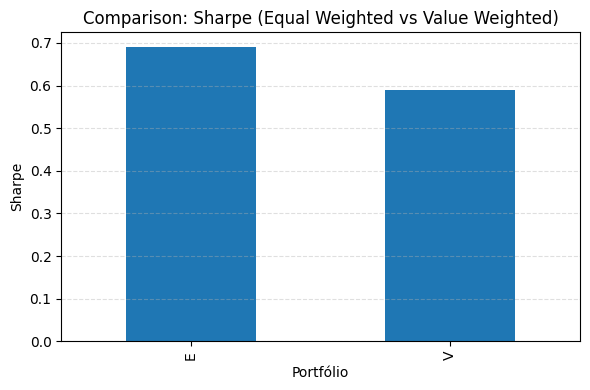

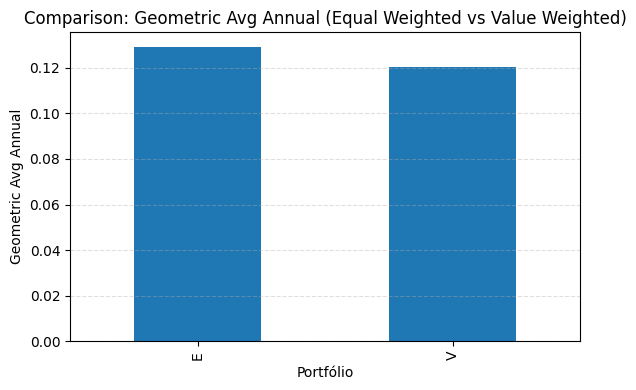

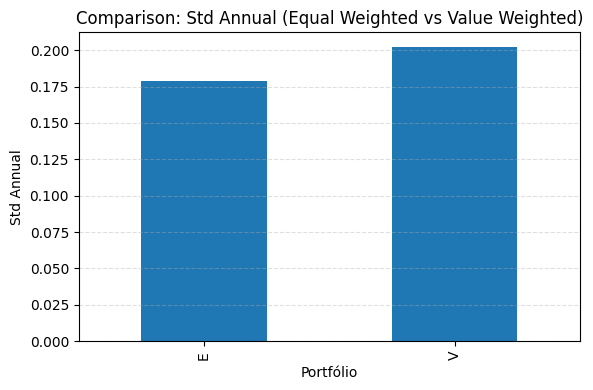

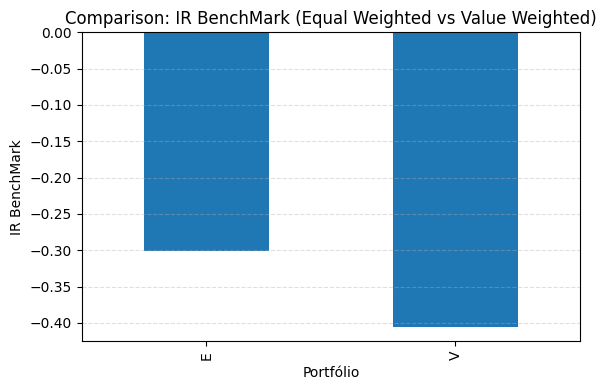

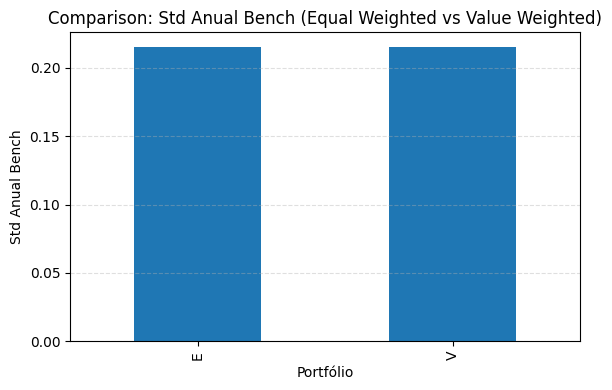

In [19]:

measures = ["Sharpe", "Geometric Avg Annual", "Std Annual", "IR BenchMark", "Std Anual Bench"]
values_W = [Sharpe_W, GeometricAvg_Annual_W, Std_Annual_W, IR_BM_W, std_Anual_bench_W]
values_V = [Sharpe_V, GeometricAvg_Annual_V, Std_Annual_V, IR_BM_V, std_Anual_bench_V]

df = pd.DataFrame({"E": values_W, "V": values_V}, index=measures)

for metric in measures:
    fig, ax = plt.subplots(figsize=(6, 4))
    df.loc[metric].plot(kind="bar", ax=ax) 
    ax.set_title(f"Comparison: {metric} (Equal Weighted vs Value Weighted)")
    ax.set_xlabel("Portfólio")
    ax.set_ylabel(metric)
    ax.grid(axis="y", linestyle="--", alpha=0.4)
    plt.tight_layout()
    plt.show()

# Part C

In [20]:
df = tri_30.copy()
df = df.set_index("Dates").sort_index()

assets = df.select_dtypes(include=[np.number]).columns
df = df[assets]

month_end_tri = df.resample("M").last()
monthly_returns = month_end_tri.pct_change().dropna(how="all")

monthly_returns

/var/folders/pm/ps47mfm943x_nqjshcjsk5ch0000gn/T/ipykernel_63056/870848131.py:7: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  month_end_tri = df.resample("M").last()


,ARE UN Equity,ATO UN Equity,AVY UN Equity,BK UN Equity,CHRW UW Equity,CLX UN Equity,FCX UN Equity,GIS UN Equity,GM UN Equity,GOOGL UW Equity,...,ON UW Equity,PFE UN Equity,PHM UN Equity,PRU UN Equity,RCL UN Equity,SJM UN Equity,SNA UN Equity,UDR UN Equity,VLO UN Equity,ZBH UN Equity
Dates,,,,,,,,,,,,,,,,,,,,,
2014-02-28,0.033081,-0.031940,0.011163,0.001251,-0.114110,-0.011212,0.006479,0.041858,0.003326,0.029371,...,0.117225,0.065211,0.032972,0.008580,0.072246,0.043982,0.124538,0.060395,-0.056100,-0.001383
2014-03-31,0.011354,0.022343,0.023031,0.102814,0.017051,0.008364,0.013795,0.035778,-0.040804,-0.083199,...,0.006424,0.000312,-0.083505,0.000828,0.030796,-0.027699,0.011682,0.000775,0.106712,0.010280
2014-04-30,0.017365,0.082962,-0.039668,-0.035471,0.124261,0.038689,0.049285,0.031338,0.001742,-0.041090,...,0.001064,-0.026153,-0.041687,-0.046899,-0.026210,-0.005761,0.022208,0.011322,0.076648,0.023473
2014-05-31,0.030750,-0.011214,0.041924,0.020374,0.016298,-0.011908,-0.009310,0.036024,0.002901,0.068763,...,-0.076514,-0.044261,0.063618,0.024970,0.045667,0.067477,0.014815,0.064192,-0.015156,0.077995
2014-06-30,0.029997,0.065868,0.017932,0.084489,0.071936,0.019860,0.071953,-0.043510,0.058356,0.022776,...,0.051784,0.001687,0.033305,0.080452,0.005607,0.038697,0.010658,0.040334,-0.106155,-0.002618
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-04-30,-0.214571,0.039139,-0.038546,-0.035168,-0.128711,-0.025140,-0.044058,-0.041052,-0.038061,0.026900,...,-0.024330,-0.036700,-0.002140,-0.080319,0.046096,-0.018071,-0.068841,-0.062720,-0.120996,-0.089503
2025-05-31,-0.033994,-0.031688,0.038689,0.101977,0.075656,-0.073225,0.067999,-0.043708,0.096595,0.081488,...,0.058438,-0.019117,-0.044356,0.024387,0.195710,-0.022260,0.028810,-0.010745,0.120443,-0.105580
2025-06-30,0.053569,-0.003685,-0.007523,0.028213,0.006262,-0.089553,0.126559,-0.045153,-0.004928,0.027368,...,0.247263,0.031928,0.078191,0.034171,0.222026,-0.127967,-0.029837,-0.014482,0.042258,-0.007826


# Optimal Weights

$$
\text{Optimal Weights} = \frac{\Sigma^{-1} \mu}{\mathbf{1}^T \Sigma^{-1} \mu}
$$


In [21]:
df = tri_30.copy()
df = df.set_index(pd.to_datetime(df["Dates"])).drop(columns=["Dates"]).sort_index()
df = df.select_dtypes(include=[np.number])

month_end_tri = df.resample("M").last()
monthly_returns = month_end_tri.pct_change().dropna(how="all")
monthly_returns

/var/folders/pm/ps47mfm943x_nqjshcjsk5ch0000gn/T/ipykernel_63056/1732495451.py:5: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  month_end_tri = df.resample("M").last()


,ARE UN Equity,ATO UN Equity,AVY UN Equity,BK UN Equity,CHRW UW Equity,CLX UN Equity,FCX UN Equity,GIS UN Equity,GM UN Equity,GOOGL UW Equity,...,ON UW Equity,PFE UN Equity,PHM UN Equity,PRU UN Equity,RCL UN Equity,SJM UN Equity,SNA UN Equity,UDR UN Equity,VLO UN Equity,ZBH UN Equity
Dates,,,,,,,,,,,,,,,,,,,,,
2014-02-28,0.033081,-0.031940,0.011163,0.001251,-0.114110,-0.011212,0.006479,0.041858,0.003326,0.029371,...,0.117225,0.065211,0.032972,0.008580,0.072246,0.043982,0.124538,0.060395,-0.056100,-0.001383
2014-03-31,0.011354,0.022343,0.023031,0.102814,0.017051,0.008364,0.013795,0.035778,-0.040804,-0.083199,...,0.006424,0.000312,-0.083505,0.000828,0.030796,-0.027699,0.011682,0.000775,0.106712,0.010280
2014-04-30,0.017365,0.082962,-0.039668,-0.035471,0.124261,0.038689,0.049285,0.031338,0.001742,-0.041090,...,0.001064,-0.026153,-0.041687,-0.046899,-0.026210,-0.005761,0.022208,0.011322,0.076648,0.023473
2014-05-31,0.030750,-0.011214,0.041924,0.020374,0.016298,-0.011908,-0.009310,0.036024,0.002901,0.068763,...,-0.076514,-0.044261,0.063618,0.024970,0.045667,0.067477,0.014815,0.064192,-0.015156,0.077995
2014-06-30,0.029997,0.065868,0.017932,0.084489,0.071936,0.019860,0.071953,-0.043510,0.058356,0.022776,...,0.051784,0.001687,0.033305,0.080452,0.005607,0.038697,0.010658,0.040334,-0.106155,-0.002618
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-04-30,-0.214571,0.039139,-0.038546,-0.035168,-0.128711,-0.025140,-0.044058,-0.041052,-0.038061,0.026900,...,-0.024330,-0.036700,-0.002140,-0.080319,0.046096,-0.018071,-0.068841,-0.062720,-0.120996,-0.089503
2025-05-31,-0.033994,-0.031688,0.038689,0.101977,0.075656,-0.073225,0.067999,-0.043708,0.096595,0.081488,...,0.058438,-0.019117,-0.044356,0.024387,0.195710,-0.022260,0.028810,-0.010745,0.120443,-0.105580
2025-06-30,0.053569,-0.003685,-0.007523,0.028213,0.006262,-0.089553,0.126559,-0.045153,-0.004928,0.027368,...,0.247263,0.031928,0.078191,0.034171,0.222026,-0.127967,-0.029837,-0.014482,0.042258,-0.007826


In [22]:
sofr = pd.read_excel("SOFR.xlsx")
sofr["Data"] = pd.to_datetime(sofr["Data"])
sofr = sofr.set_index("Data").sort_index()

rf_ann = sofr["Price"].astype(float)

# Treat as daily overnight annualized rate; convert to daily simple return via ACT/360,
# then compound within each calendar month to get the *monthly* risk-free return.
rf_daily_simple = rf_ann / 360.0
monthly_rf = ((1.0 + rf_daily_simple).resample("M").prod() - 1.0).dropna()

/var/folders/pm/ps47mfm943x_nqjshcjsk5ch0000gn/T/ipykernel_63056/48486290.py:10: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_rf = ((1.0 + rf_daily_simple).resample("M").prod() - 1.0).dropna()


In [23]:
mr = monthly_returns.copy()
rf = monthly_rf.copy()

common_idx = mr.index.intersection(rf.index)
mr = mr.loc[common_idx]
rf = rf.loc[common_idx]

monthly_excess = mr.sub(rf, axis=0).dropna(how="all")

/opt/homebrew/lib/python3.10/site-packages/numpy/linalg/_linalg.py:3383: RuntimeWarning: divide by zero encountered in matmul
  return _core_matmul(x1, x2)
/opt/homebrew/lib/python3.10/site-packages/numpy/linalg/_linalg.py:3383: RuntimeWarning: overflow encountered in matmul
  return _core_matmul(x1, x2)
/opt/homebrew/lib/python3.10/site-packages/numpy/linalg/_linalg.py:3383: RuntimeWarning: invalid value encountered in matmul
  return _core_matmul(x1, x2)
/var/folders/pm/ps47mfm943x_nqjshcjsk5ch0000gn/T/ipykernel_63056/2093140310.py:25: RuntimeWarning: divide by zero encountered in matmul
  returns = W @ mu
/var/folders/pm/ps47mfm943x_nqjshcjsk5ch0000gn/T/ipykernel_63056/2093140310.py:25: RuntimeWarning: overflow encountered in matmul
  returns = W @ mu
/var/folders/pm/ps47mfm943x_nqjshcjsk5ch0000gn/T/ipykernel_63056/2093140310.py:25: RuntimeWarning: invalid value encountered in matmul
  returns = W @ mu


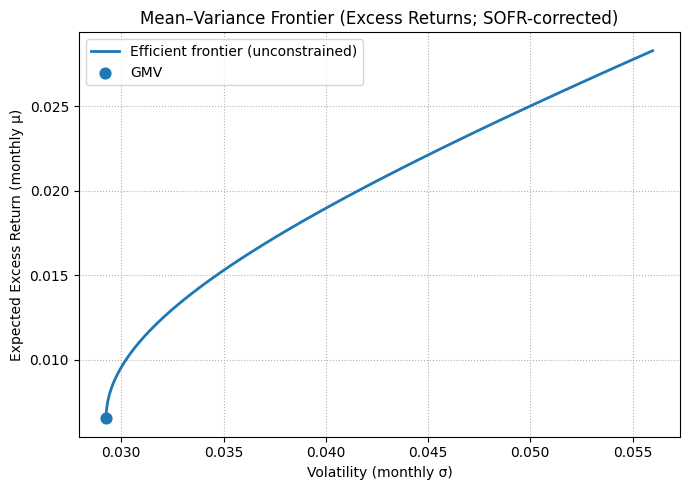

In [24]:
mu = monthly_excess.mean().to_numpy()
Sigma = monthly_excess.cov().to_numpy()
n = mu.size

invS = np.linalg.pinv(Sigma)
ones = np.ones(n)

A = ones @ invS @ ones
B = ones @ invS @ mu
C = mu   @ invS @ mu
D = A * C - B * B

w_gmv = (invS @ ones) / A
mu_gmv = float(w_gmv @ mu)
sig_gmv = float(np.sqrt(1.0 / A))

def w_for_r(r):
    lam1 = (C - B * r) / D
    lam2 = (A * r - B) / D
    return lam1 * (invS @ ones) + lam2 * (invS @ mu)

# Sweep target returns from GMV return to the max asset mean
target_returns = np.linspace(mu_gmv, float(mu.max()), 120)
W = np.vstack([w_for_r(r) for r in target_returns])
returns = W @ mu
volatilities = np.sqrt(np.einsum("ij,jk,ik->i", W, Sigma, W))

# Keep only the efficient arc (should already be efficient since we start at mu_gmv)
order = np.argsort(volatilities)
vols_eff = volatilities[order]
rets_eff = returns[order]

plt.figure(figsize=(7, 5))
plt.plot(vols_eff, rets_eff, lw=2, label="Efficient frontier (unconstrained)")
plt.scatter([sig_gmv], [mu_gmv], s=60, zorder=3, label="GMV")
plt.xlabel("Volatility (monthly σ)")
plt.ylabel("Expected Excess Return (monthly μ)")
plt.title("Mean–Variance Frontier (Excess Returns; SOFR-corrected)")
plt.grid(True, ls=":")
plt.legend()
plt.tight_layout()
plt.show()

In [25]:
threshold = 0.6

corr = monthly_excess.corr()
upper = corr.where(np.triu(np.ones(corr.shape), k=1).astype(bool))

pairs = upper.stack().reset_index()
pairs.columns = ["asset_1", "asset_2", "corr"]

most_corr = pairs[pairs["corr"].abs() > threshold].sort_values("corr", ascending=False).reset_index(drop=True)

for _, row in most_corr.iterrows():
	print(f"{row['asset_1']}  -  {row['asset_2']}: correlation = {row['corr']:.3f}")

BK UN Equity  -  PRU UN Equity: correlation = 0.712
HLT UN Equity  -  RCL UN Equity: correlation = 0.690
PRU UN Equity  -  SNA UN Equity: correlation = 0.674
ARE UN Equity  -  UDR UN Equity: correlation = 0.664
IVZ UN Equity  -  PRU UN Equity: correlation = 0.653
PRU UN Equity  -  RCL UN Equity: correlation = 0.649
BK UN Equity  -  IVZ UN Equity: correlation = 0.624
PRU UN Equity  -  VLO UN Equity: correlation = 0.611
GM UN Equity  -  NWSA UW Equity: correlation = 0.606
RCL UN Equity  -  SNA UN Equity: correlation = 0.605
GM UN Equity  -  ON UW Equity: correlation = 0.604


In [26]:
least_corr = pairs[pairs["corr"].abs() < threshold].copy()
least_corr["abs_corr"] = least_corr["corr"].abs()
least_corr = least_corr.sort_values("abs_corr", ascending=True).reset_index(drop=True)
least_corr = least_corr.drop(columns="abs_corr")

for _, row in least_corr.iterrows():
    print(f"{row['asset_1']}  -  {row['asset_2']}: correlation = {row['corr']:.3f}")


CHRW UW Equity  -  NFLX UW Equity: correlation = -0.004
GIS UN Equity  -  JBL UN Equity: correlation = 0.004
JBL UN Equity  -  SJM UN Equity: correlation = -0.005
GIS UN Equity  -  RCL UN Equity: correlation = 0.021
ATO UN Equity  -  NFLX UW Equity: correlation = 0.021
CLX UN Equity  -  PRU UN Equity: correlation = 0.022
NFLX UW Equity  -  PFE UN Equity: correlation = 0.031
GIS UN Equity  -  IVZ UN Equity: correlation = 0.033
RCL UN Equity  -  SJM UN Equity: correlation = 0.035
CLX UN Equity  -  JBL UN Equity: correlation = 0.035
NFLX UW Equity  -  SJM UN Equity: correlation = 0.036
CLX UN Equity  -  NFLX UW Equity: correlation = 0.037
GIS UN Equity  -  ON UW Equity: correlation = 0.047
CLX UN Equity  -  RCL UN Equity: correlation = 0.048
GIS UN Equity  -  NFLX UW Equity: correlation = -0.054
GIS UN Equity  -  GOOGL UW Equity: correlation = 0.055
CLX UN Equity  -  HLT UN Equity: correlation = 0.057
ON UW Equity  -  SJM UN Equity: correlation = 0.057
CLX UN Equity  -  IVZ UN Equity: cor

In [27]:
corr = monthly_excess.corr()
upper = corr.where(np.triu(np.ones(corr.shape), k=1).astype(bool))
pairs = upper.stack().reset_index()
pairs.columns = ["asset_1", "asset_2", "corr"]

k = 10
top_pos = pairs.sort_values("corr", ascending=False).head(k)
top_neg = pairs.sort_values("corr", ascending=True).head(k)

print("\nMost positively correlated:")
for _, r in top_pos.iterrows():
    print(f"{r['asset_1']} - {r['asset_2']}: {r['corr']:.3f}")

print("\nMost negatively correlated:")
for _, r in top_neg.iterrows():
    print(f"{r['asset_1']} - {r['asset_2']}: {r['corr']:.3f}")


Most positively correlated:
BK UN Equity - PRU UN Equity: 0.712
HLT UN Equity - RCL UN Equity: 0.690
PRU UN Equity - SNA UN Equity: 0.674
ARE UN Equity - UDR UN Equity: 0.664
IVZ UN Equity - PRU UN Equity: 0.653
PRU UN Equity - RCL UN Equity: 0.649
BK UN Equity - IVZ UN Equity: 0.624
PRU UN Equity - VLO UN Equity: 0.611
GM UN Equity - NWSA UW Equity: 0.606
RCL UN Equity - SNA UN Equity: 0.605

Most negatively correlated:
CLX UN Equity - FCX UN Equity: -0.075
CLX UN Equity - VLO UN Equity: -0.074
GIS UN Equity - NFLX UW Equity: -0.054
JBL UN Equity - SJM UN Equity: -0.005
CHRW UW Equity - NFLX UW Equity: -0.004
GIS UN Equity - JBL UN Equity: 0.004
GIS UN Equity - RCL UN Equity: 0.021
ATO UN Equity - NFLX UW Equity: 0.021
CLX UN Equity - PRU UN Equity: 0.022
NFLX UW Equity - PFE UN Equity: 0.031


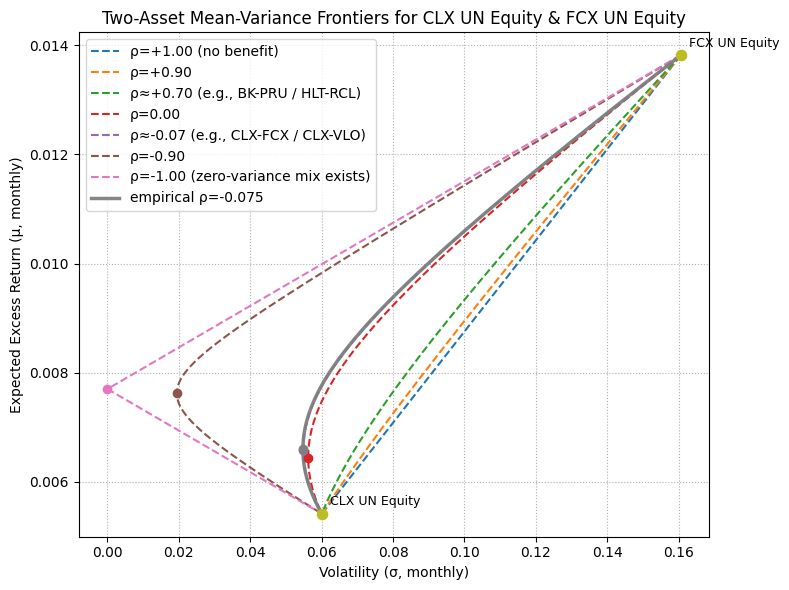

      rho  w_CLX UN Equity  w_FCX UN Equity     mu_p      sigma_p
 1.000000         1.000000         0.000000 0.005413 6.003921e-02
 0.700000         1.000000         0.000000 0.005413 6.003921e-02
 0.000000         0.877354         0.122646 0.006444 5.623705e-02
-0.070000         0.860786         0.139214 0.006583 5.485368e-02
-1.000000         0.727863         0.272137 0.007700 6.585445e-10
-0.074507         0.859769         0.140231 0.006592 5.475839e-02


In [28]:
pair = ("CLX UN Equity", "FCX UN Equity")
cols = [c for c in pair if c in monthly_excess.columns]
if len(cols) < 2:
    cols = monthly_excess.columns[:2].tolist()
a, b = cols

R = monthly_excess[[a, b]].dropna()
mu1, mu2 = R.mean().values
s1, s2   = R.std().values
rho_emp  = float(R.corr().iloc[0,1])

def two_asset_frontier(mu1, mu2, s1, s2, rho, w):
    ret = w*mu1 + (1-w)*mu2
    var = (w**2)*(s1**2) + ((1-w)**2)*(s2**2) + 2*w*(1-w)*rho*s1*s2
    return ret, np.sqrt(np.maximum(var, 0.0))

def gmv_weight(s1, s2, rho):
    num = s2**2 - rho*s1*s2
    den = s1**2 + s2**2 - 2*rho*s1*s2
    w = num / den
    return np.clip(w, 0.0, 1.0)


rhos = [1.0, 0.9, 0.7, 0.0, -0.07, -0.9, -1.0, rho_emp]
labels = {
    1.0:   "ρ=+1.00 (no benefit)",
    0.9:   "ρ=+0.90",
    0.7:   "ρ≈+0.70 (e.g., BK-PRU / HLT-RCL)",
    0.0:   "ρ=0.00",
    -0.07: "ρ≈-0.07 (e.g., CLX-FCX / CLX-VLO)",
    -0.9:  "ρ=-0.90",
    -1.0:  "ρ=-1.00 (zero-variance mix exists)",
}

w = np.linspace(0.0, 1.0, 401)

plt.figure(figsize=(8, 6))
for rho in rhos:
    ret, vol = two_asset_frontier(mu1, mu2, s1, s2, rho, w)
    if rho == rho_emp:
        plt.plot(vol, ret, lw=2.5, label=f"empirical ρ={rho_emp:.3f}", alpha=0.95)
    else:
        plt.plot(vol, ret, lw=1.5, ls="--", label=labels.get(rho, f"ρ={rho:.2f}"))
    wg = gmv_weight(s1, s2, rho)
    rg, sg = two_asset_frontier(mu1, mu2, s1, s2, rho, wg)
    plt.scatter([sg], [rg], s=36, zorder=3)


plt.scatter([s1, s2], [mu1, mu2], s=54, zorder=4)
plt.annotate(a, (s1, mu1), xytext=(6, 6), textcoords="offset points", fontsize=9)
plt.annotate(b, (s2, mu2), xytext=(6, 6), textcoords="offset points", fontsize=9)

plt.xlabel("Volatility (σ, monthly)")
plt.ylabel("Expected Excess Return (μ, monthly)")
plt.title(f"Two-Asset Mean-Variance Frontiers for {a} & {b}")
plt.grid(True, ls=":")
plt.legend()
plt.tight_layout()
plt.show()


rows = []
for rho in [1.0, 0.7, 0.0, -0.07, -1.0, rho_emp]:
    wg = gmv_weight(s1, s2, rho)
    rg, sg = two_asset_frontier(mu1, mu2, s1, s2, rho, wg)
    rows.append({"rho": float(rho if rho != rho_emp else rho_emp),
        		"w_"+a: float(wg), "w_"+b: float(1-wg),
                "mu_p": float(rg), "sigma_p": float(sg)})
gmv_table = pd.DataFrame(rows)
print(gmv_table.to_string(index=False))

# Project 3

Calculating the Betas for the 30 stocks

$$
\beta_i = \frac{Cov(R_i, R_m)}{Var(R_m)}
$$

In [ ]:

]